## HOLO version of TOML config file workbook

In [1]:
import pyopia.background
import pyopia.classify
import pyopia.instrument.silcam
import pyopia.instrument.holo
import pyopia.io
import pyopia.pipeline
import pyopia.plotting
import pyopia.process
import pyopia.statistics
import exampledata

import xarray
import os
import matplotlib.pyplot as plt

In [2]:
# Prepare folders
os.makedirs('proc', exist_ok=True)

# remove pre-existing output file (as statistics for each image are appended to it)
datafile_nc = os.path.join('proc', 'test')
if os.path.isfile(datafile_nc + '-STATS.nc'):
  os.remove(datafile_nc + '-STATS.nc')

## Load a TOML config file containing all setttings, and pipeline steps

This creates a dict of all settings, which can be modified or writte in the same way as any other dictionary in python. This has a slightly different structure that the old 'steps' dict, but follows the same principle (look in the example config.toml file used below for more details).

In [3]:
toml_settings = pyopia.io.load_toml('config-holo.toml')
toml_settings

{'general': {'raw_files': 'holo_test_data_01/*.pgm', 'pixel_size': 4.4},
 'steps': {'initial': {'pipeline_class': 'pyopia.instrument.holo.Initial',
   'wavelength': 658,
   'n': 1.33,
   'offset': 27,
   'minZ': 0,
   'maxZ': 50,
   'stepZ': 0.5},
  'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'createbackground': {'pipeline_class': 'pyopia.background.CreateBackground',
   'average_window': 10,
   'instrument_module': 'holo'},
  'load': {'pipeline_class': 'pyopia.instrument.holo.Load'},
  'correctbackground': {'pipeline_class': 'pyopia.background.CorrectBackgroundAccurate',
   'bgshift_function': 'accurate'},
  'reconstruct': {'pipeline_class': 'pyopia.instrument.holo.Reconstruct',
   'stack_clean': 0.02},
  'focus': {'pipeline_class': 'pyopia.instrument.holo.Focus',
   'stacksummary_function': 'max_map',
   'threshold': 0.9,
   'increase_depth_of_field': True,
   'focus_function': 'find_focus_sobel',
   'merge_adjacent_particles': 2

## Run the pipeline

(same as before, but now giving Pipeline() the toml_setting dict)

In [4]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(toml_settings)

# Load an image (from the test suite)
filename = 'holo_test_data_01/001-2043.pgm'

# Process the image to obtain the stats dataframe
stats = processing_pipeline.run(filename)

Initialising pipeline
raw_files: holo_test_data_01/*.pgm
Initial  ready with: {'wavelength': 658, 'n': 1.33, 'offset': 27, 'minZ': 0, 'maxZ': 50, 'stepZ': 0.5}  and data dict_keys(['settings', 'raw_files'])
Using first raw file from list in general settings to determine image dimensions
Build kernel with pixel_size =  4.4 um
HoloInitial done 2023-09-27 23:08:16.515955


2023-09-27 23:08:19.419705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Classify  ready with: {'model_path': 'keras_model.h5'}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack'])
CreateBackground  ready with: {'average_window': 10, 'instrument_module': 'holo'}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack', 'cl'])
Pipeline ready with these data:  ['settings', 'raw_files', 'kern', 'im_stack', 'cl', 'bgstack', 'imbg']
Load  ready with: {}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack', 'cl', 'bgstack', 'imbg', 'filename'])
holo_test_data_01/001-2043.pgm
D20180706T181539.002043
2018-07-06 18:15:39.002043
CorrectBackgroundAccurate  ready with: {'bgshift_function': 'accurate'}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack', 'cl', 'bgstack', 'imbg', 'filename', 'timestamp', 'imraw'])
Reconstruct  ready with: {'stack_clean': 0.02}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack', 'cl', 'bgstack', 'imbg', 'filename', 'timestamp', 'imraw', 'imc'])
Focus  ready with: {'stacksummary_

## Load the data again

Then later, we can load the data again from NetCDF using xarray

xarray DataSets are presented nicely in notebooks (rendered poorly on GitHub's webinterface)

In [5]:
with xarray.open_dataset('proc/test-STATS.nc') as xstats:
    xstats.load()

xstats

<xarray.Dataset>
Dimensions:                     (index: 376)
Coordinates:
  * index                       (index) int32 0 1 2 3 4 ... 371 372 373 374 375
    time                        (index) datetime64[ns] 2018-07-06T18:15:39.00...
Data variables: (12/19)
    export name                 (index) object 'D20180706T181539.002043-PN0' ...
    major_axis_length           (index) float64 5.657 5.657 ... 9.165 5.657
    minor_axis_length           (index) float64 5.657 5.657 8.0 ... 8.0 5.657
    equivalent_diameter         (index) float64 5.642 5.642 ... 8.444 5.642
    feret_diameter_max          (index) float64 6.403 6.403 10.0 ... 10.0 6.403
    equivalent_diameter_area    (index) float64 5.642 5.642 ... 8.444 5.642
    ...                          ...
    probability_faecal_pellets  (index) float64 2.13e-13 2.893e-07 ... 1.532e-14
    probability_copepod         (index) float64 7.692e-12 ... 4.931e-10
    probability_diatom_chain    (index) float64 2.787e-11 ... 1.593e-11
    probability_oily_gas        (index) float64 6.935e-09 0.00108 ... 1.162e-07
    timestamp                   (index) datetime64[ns] 2018-07-06T18:15:39.00...
    saturation                  (index) float64 15.65 15.65 ... 15.65 15.65
Attributes:
    steps:           [general]\nraw_files = "holo_test_data_01/*.pgm"\npixel_...
    Modified:        2023-09-27 23:08:48.775146
    PyOpia version:  1.0.0

## Alter settings and re-process

What if we wanted to re-process this dataset with a different segmentation threshold?

### Get the TOML steps from the xarray DataSet

In [6]:
toml_steps = pyopia.pipeline.steps_from_xstats(xstats)
toml_steps

{'general': {'raw_files': 'holo_test_data_01/*.pgm', 'pixel_size': 4.4},
 'steps': {'initial': {'pipeline_class': 'pyopia.instrument.holo.Initial',
   'wavelength': 658,
   'n': 1.33,
   'offset': 27,
   'minZ': 0,
   'maxZ': 50,
   'stepZ': 0.5},
  'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'createbackground': {'pipeline_class': 'pyopia.background.CreateBackground',
   'average_window': 10,
   'instrument_module': 'holo'},
  'load': {'pipeline_class': 'pyopia.instrument.holo.Load'},
  'correctbackground': {'pipeline_class': 'pyopia.background.CorrectBackgroundAccurate',
   'bgshift_function': 'accurate'},
  'reconstruct': {'pipeline_class': 'pyopia.instrument.holo.Reconstruct',
   'stack_clean': 0.02},
  'focus': {'pipeline_class': 'pyopia.instrument.holo.Focus',
   'stacksummary_function': 'max_map',
   'threshold': 0.9,
   'increase_depth_of_field': True,
   'focus_function': 'find_focus_sobel',
   'merge_adjacent_particles': 2

### Alter the setting we want to change

In [7]:
toml_steps['steps']['focus']['stacksummary_function'] = 'std_map'

### re-process the pipeline

In [8]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(toml_steps)

# Process the image to obtain the stats dataframe
stats = processing_pipeline.run(filename)

Initialising pipeline
raw_files: holo_test_data_01/*.pgm
Initial  ready with: {'wavelength': 658, 'n': 1.33, 'offset': 27, 'minZ': 0, 'maxZ': 50, 'stepZ': 0.5}  and data dict_keys(['settings', 'raw_files'])
Using first raw file from list in general settings to determine image dimensions
Build kernel with pixel_size =  4.4 um
HoloInitial done 2023-09-27 23:09:45.878535
Classify  ready with: {'model_path': 'keras_model.h5'}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack'])
CreateBackground  ready with: {'average_window': 10, 'instrument_module': 'holo'}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack', 'cl'])
Pipeline ready with these data:  ['settings', 'raw_files', 'kern', 'im_stack', 'cl', 'bgstack', 'imbg']
Load  ready with: {}  and data dict_keys(['settings', 'raw_files', 'kern', 'im_stack', 'cl', 'bgstack', 'imbg', 'filename'])
holo_test_data_01/001-2043.pgm
D20180706T181539.002043
2018-07-06 18:15:39.002043
CorrectBackgroundAccurate  ready with: {'

### Further analysis

At this point we could write this to disc again (using the pyopia.io.write_stats function)

and/or we could build a new, correctly formatted, xarray for immediate use (which we will do here):

In [9]:
xstats_modified = pyopia.io.make_xstats(stats, toml_steps)
xstats_modified

<xarray.Dataset>
Dimensions:                     (index: 263)
Coordinates:
  * index                       (index) int64 0 1 2 3 4 ... 258 259 260 261 262
    time                        (index) datetime64[ns] 2018-07-06T18:15:39.00...
Data variables: (12/19)
    major_axis_length           (index) float64 9.165 5.657 ... 5.657 5.657
    minor_axis_length           (index) float64 6.831 5.657 ... 5.657 5.657
    equivalent_diameter         (index) float64 7.818 5.642 14.0 ... 5.642 5.642
    feret_diameter_max          (index) float64 9.434 6.403 17.2 ... 6.403 6.403
    equivalent_diameter_area    (index) float64 7.818 5.642 14.0 ... 5.642 5.642
    minr                        (index) float64 4.0 4.0 ... 1.179e+03 1.192e+03
    ...                          ...
    probability_copepod         (index) float64 5.55e-10 8.757e-08 ... 2.418e-11
    probability_diatom_chain    (index) float64 4.467e-13 ... 9.662e-15
    probability_oily_gas        (index) float64 2.756e-12 ... 1.206e-10
    export name                 (index) object 'D20180706T181539.002043-PN0' ...
    timestamp                   (index) datetime64[ns] 2018-07-06T18:15:39.00...
    saturation                  (index) float64 26.53 26.53 ... 26.53 26.53
Attributes:
    steps:           [general]\nraw_files = "holo_test_data_01/*.pgm"\npixel_...
    Modified:        2023-09-27 23:10:30.251046
    PyOpia version:  1.0.0

### Plotting

We can plot directly from xarray in exactly the same way as from the Pandas DataFrame (so it doesn't matter which you use here). The benefit of 'xstats' as an xarray is that it now contains it's own metadata

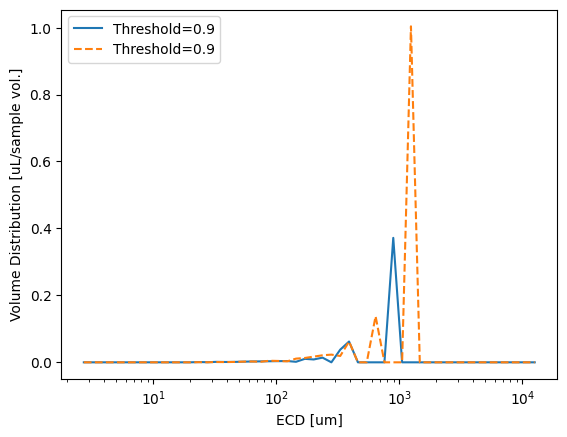

In [11]:
dias, vd = pyopia.statistics.vd_from_stats(xstats, pyopia.pipeline.steps_from_xstats(xstats)['general']['pixel_size'])

plt.plot(dias, vd, label=f"Threshold={pyopia.pipeline.steps_from_xstats(xstats)['steps']['focus']['threshold']}")
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')

dias_modified, vd_modified = pyopia.statistics.vd_from_stats(xstats_modified, pyopia.pipeline.steps_from_xstats(xstats_modified)['general']['pixel_size'])

plt.plot(dias_modified, vd_modified, '--', label=f"Threshold={pyopia.pipeline.steps_from_xstats(xstats_modified)['steps']['focus']['threshold']}")

plt.legend()
plt.show()